In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install imutils
!pip install lime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7ff7653efdabd868854d7fa81033f52882f57759e2dbde1e8147f1ca7718eec5
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import os
import cv2
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

# XAI Libraries
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

%matplotlib inline

In [ ]:
# (Cell for quantify_image and load_split functions - no changes)
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

def load_split(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        features = quantify_image(image)
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

In [ ]:
def train_models(dataset):
    models = {
        "Rf": {"classifier": RandomForestClassifier(random_state=1), "accuracy": 0, "sensitivity": 0, "specificity": 0},
        "Xgb": {"classifier": XGBClassifier(), "accuracy": 0, "sensitivity": 0, "specificity": 0}
    }
    path = "/content/drive/My Drive/Dataset/" + dataset
    trainingPath = os.path.sep.join([path, "training"])
    testingPath = os.path.sep.join([path, "testing"])
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)
    for model in models:
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions).ravel()
        tn, fp, fn, tp = cm
        models[model]["accuracy"] = (tp + tn) / float(cm.sum())
        models[model]["sensitivity"] = tp / float(tp + fn)
        models[model]["specificity"] = tn / float(tn + fp)
    return models

spiralModels = train_models('drawings/spiral')
waveModels = train_models('drawings/wave')

In [ ]:
print("Random Forest vs XGBoost Classifier (Spiral Drawings)\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralModels['Rf'][metric]*100, spiralModels['Xgb'][metric]*100))

Random Forest vs XGBoost Classifier (Spiral Drawings)

Accuracy: 
Random Forest=80.00%, XGBoost=73.33% 

Sensitivity: 
Random Forest=66.67%, XGBoost=73.33% 

Specificity: 
Random Forest=93.33%, XGBoost=73.33% 



In [ ]:
print("\nRandom Forest vs XGBoost Classifier (Wave Drawings)\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forest={:.2f}%, XGBoost={:.2f}% \n".format(
        waveModels['Rf'][metric]*100, waveModels['Xgb'][metric]*100))


Random Forest vs XGBoost Classifier (Wave Drawings)

Accuracy: 
Random Forest=73.33%, XGBoost=73.33% 

Sensitivity: 
Random Forest=66.67%, XGBoost=80.00% 

Specificity: 
Random Forest=80.00%, XGBoost=66.67% 



Spiral Image Predictions:


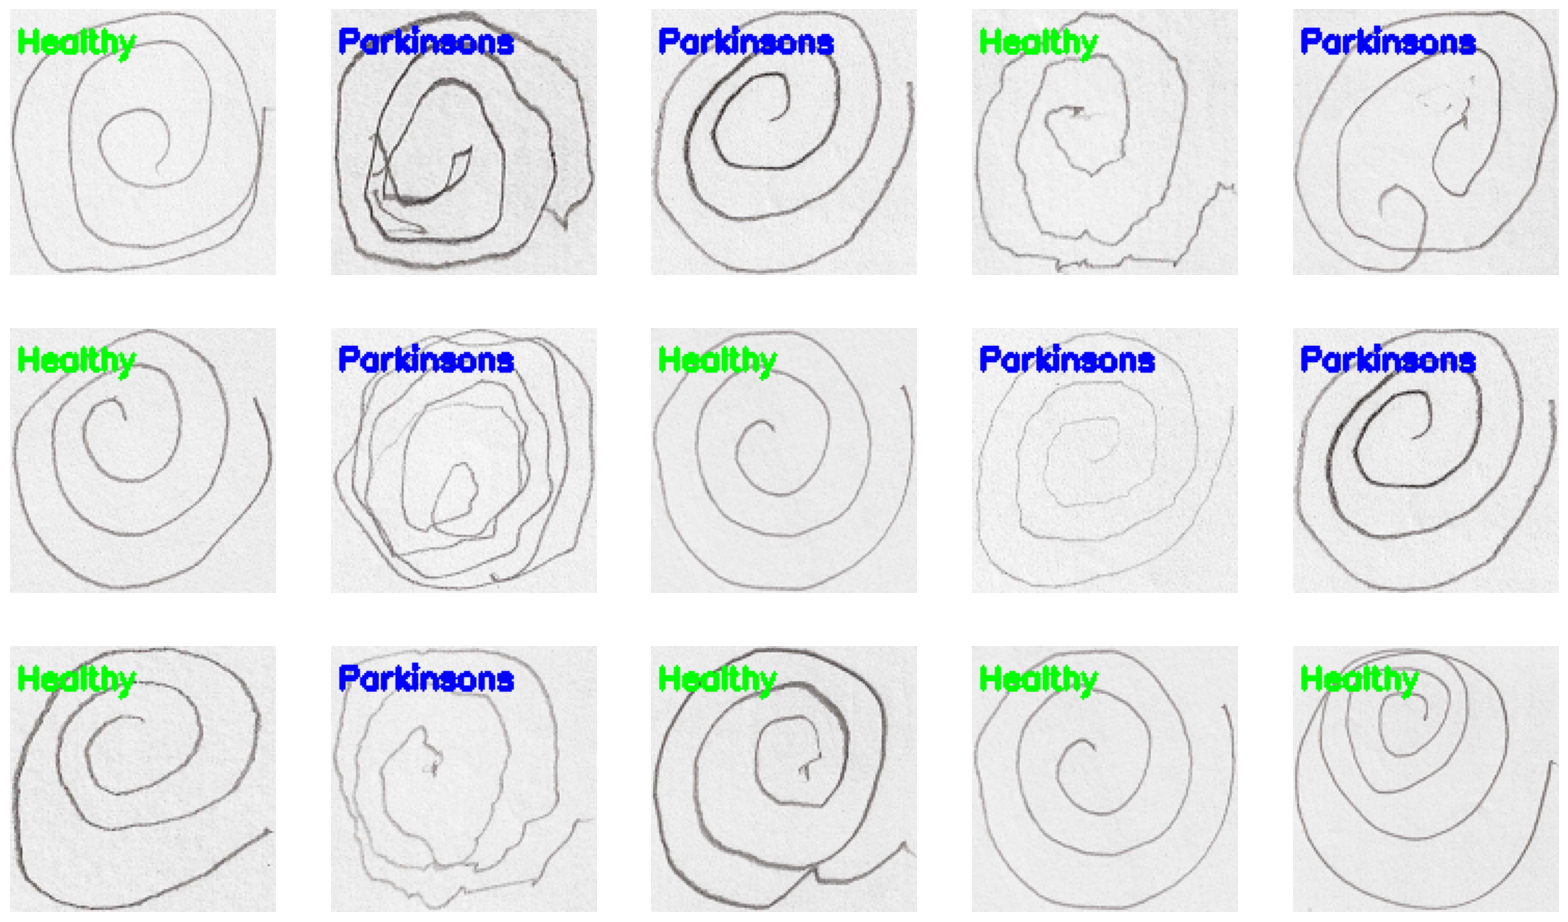


Wave Image Predictions:


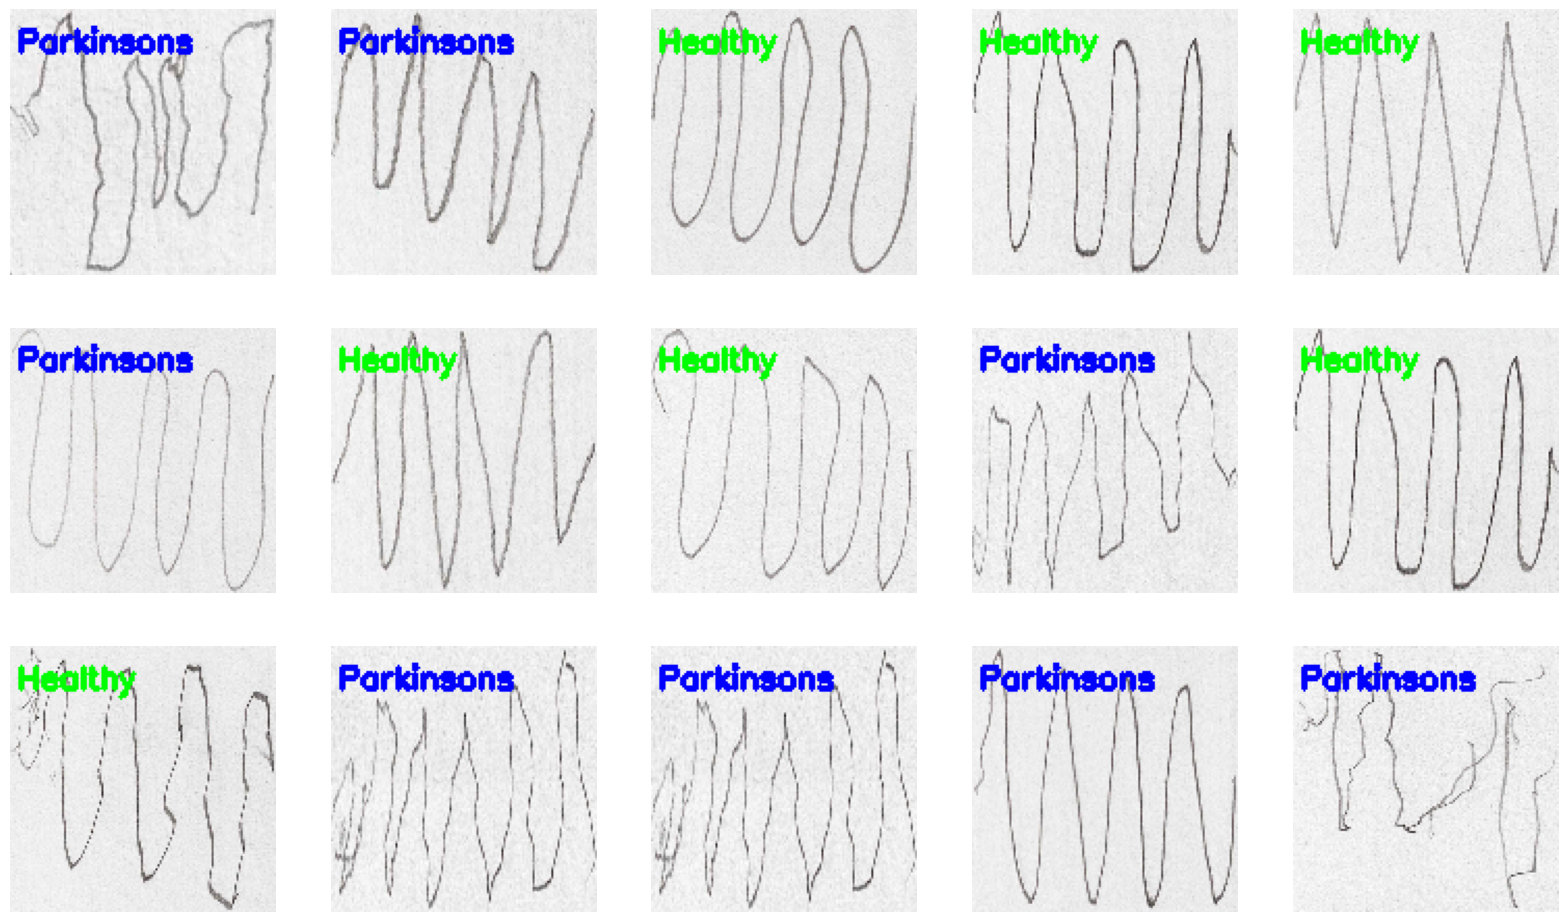

In [ ]:
def test_prediction(model, testingPath):
    """
    Tests the model on random images and visualizes the predictions.
    """
    testingPaths = list(paths.list_images(testingPath))
    output_images = []

    for _ in range(15):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)

    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

# Visualize predictions for spiral images
print("Spiral Image Predictions:")
test_prediction(spiralModels['Rf']['classifier'], "/content/drive/My Drive/Dataset/drawings/spiral/testing")

# Visualize predictions for wave images
print("\nWave Image Predictions:")
test_prediction(waveModels['Xgb']['classifier'], "/content/drive/My Drive/Dataset/drawings/wave/testing")

--- LIME Explanations for Spiral Drawings (Random Forest Model) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

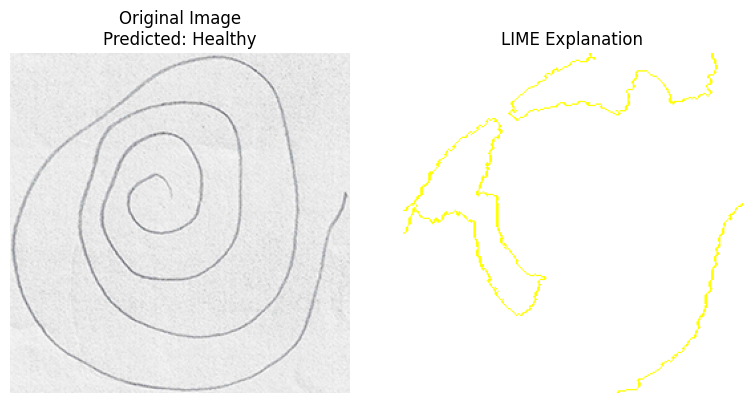

  0%|          | 0/1000 [00:00<?, ?it/s]

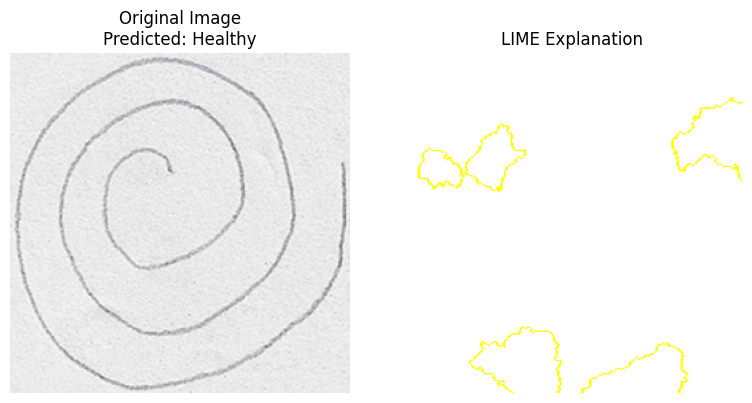


--- LIME Explanations for Wave Drawings (XGBoost Model) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

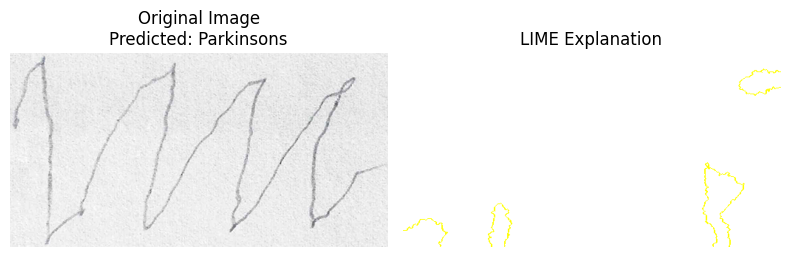

  0%|          | 0/1000 [00:00<?, ?it/s]

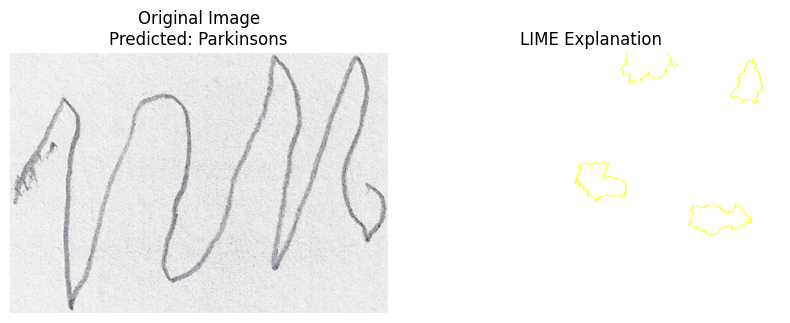

In [ ]:
def explain_prediction_lime(model, image_path):
    # LIME requires a function that takes numpy arrays (images)
    # and returns prediction probabilities
    def prediction_fn(images):
        preprocessed_images = []
        for img in images:
            # Preprocess the image in the same way as the training data
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_resized = cv2.resize(img_gray, (200, 200))
            _, img_threshold = cv2.threshold(img_resized, 0, 255,
                                           cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
            features = quantify_image(img_threshold)
            preprocessed_images.append(features)

        # Return prediction probabilities for both classes
        return model.predict_proba(np.array(preprocessed_images))

    # Read and prepare the image to be explained
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # LIME expects RGB

    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Generate the explanation
    # We explain the top-predicted class
    explanation = explainer.explain_instance(image,
                                             prediction_fn,
                                             top_labels=1,
                                             hide_color=0,
                                             num_samples=1000)

    # Get the image and mask for the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=5,
                                                hide_rest=False)

    # Get the predicted label
    pred_label_index = model.predict_proba(np.array([quantify_image(cv2.threshold(cv2.resize(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), (200, 200)), 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1])]))[0].argmax()
    pred_label = "Parkinsons" if pred_label_index == 1 else "Healthy"

    # Display the original image and the explanation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title(f'Original Image\nPredicted: {pred_label}')
    ax1.axis('off')

    ax2.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax2.set_title("LIME Explanation")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# --- Now let's use the function ---

# Get a few random test images
testingPathSpiral = "/content/drive/My Drive/Dataset/drawings/spiral/testing"
testingPathWave = "/content/drive/My Drive/Dataset/drawings/wave/testing"
spiral_test_images = list(paths.list_images(testingPathSpiral))
wave_test_images = list(paths.list_images(testingPathWave))

print("--- LIME Explanations for Spiral Drawings (Random Forest Model) ---")
for i in range(2):
    image_path = random.choice(spiral_test_images)
    explain_prediction_lime(spiralModels['Rf']['classifier'], image_path)

print("\n--- LIME Explanations for Wave Drawings (XGBoost Model) ---")
for i in range(2):
    image_path = random.choice(wave_test_images)
    explain_prediction_lime(waveModels['Xgb']['classifier'], image_path)

Used Lime library for explainable ai